In [33]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

import theano
import theano.tensor as T
import pymc3 as pm
theano.config.optimizer_including

from io import StringIO
import sys

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Data Preparation
path_to_data = os.pardir+"/../data/input_data/jan_models/"

geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[10,1,10], 
                        path_o = path_to_data + "model1_orientations.csv",
                        path_i = path_to_data + "model1_surface_points.csv") 
geo_data.delete_surfaces('rock1',remove_data=True)
geo_data.delete_surface_points([1,3,4,5])
geo_data.modify_surface_points([0, 2], Y=500)

Active grids: ['regular']


,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,100,500,600,0.2501,0.5001,0.5001,rock2,Default series,1,1,1.000000e-08
2,900,500,600,0.7501,0.5001,0.5001,rock2,Default series,1,1,1.000000e-08


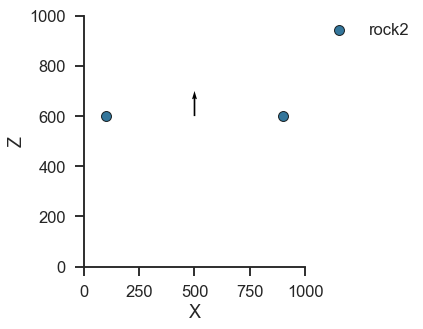

In [3]:
gp.plot.plot_data(geo_data)

In [4]:
gp.set_interpolation_data(geo_data, theano_optimizer='fast_compile',
                         verbose=['compare'])

Compiling theano function...
Compilation Done!


In [5]:
# Cleaning buffer
old_stdout = sys.stdout
mystdout = sys.stdout = StringIO()

# Computing model
gp.compute_model(geo_data)

# Black magic update
sys.stdout = old_stdout

# Split print strings
output = mystdout.getvalue().split('\n')

# Init parameters
n_surface_op_float_sigmoid = []
n_surface_0 = []
n_surface_1 = []
a = []
b = []
drift = []

for s in output:
    if 'n_surface_op_float_sigmoid __str__' in s:
        n_surface_op_float_sigmoid.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))
    if 'n_surface_0 __str__' in s:
        n_surface_0.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))
    if 'n_surface_1 __str__' in s:
        n_surface_1.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))
    if 'a __str__' in s:
        a.append(float(s[s.find('= ')+2:]))
    if 'b __str__' in s:
        b.append(float(s[s.find('= ')+2:]))
    if 'drift[slice_init:slice_init+1][0] __str__' in s:
        drift.append(np.fromstring(s[s.find('[[')+2:-2], dtype='float', sep=' '))

a, b, n_surface_0, n_surface_1, drift

../../../gempy/core/solution.py:258: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.
  warnings.warn('Surfaces not computed due to: ' + str(e))


([1.44895, 1.0002],
 [1.0002, 0.30145],
 [array([1.]), array([2.])],
 [array([1.]), array([-1.])],
 [array([1.]), array([2.])])

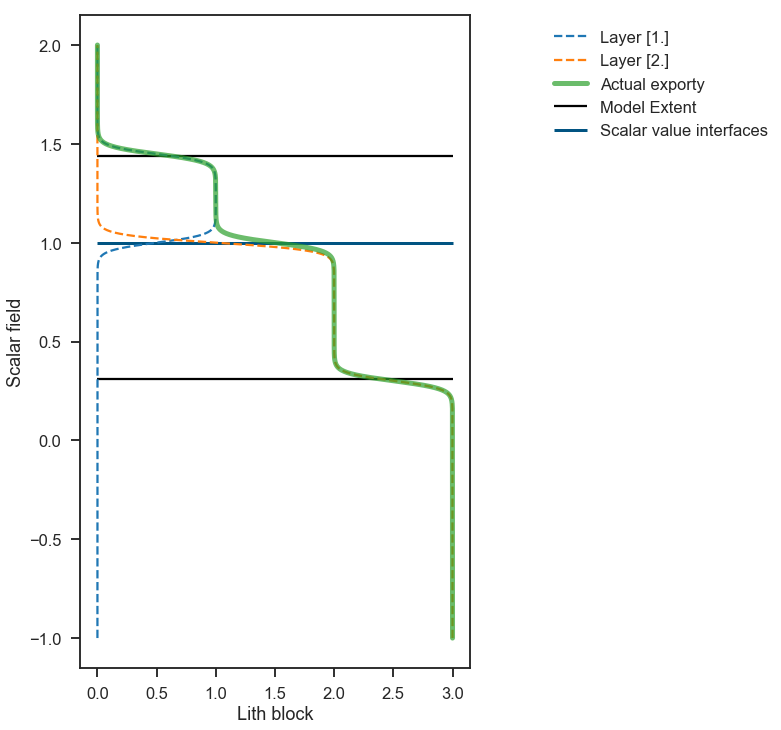

In [6]:
from gempy.utils.gradient import plot_sig
plot_sig(n_surface_0[:], n_surface_1, a, b, drift, Z_x = np.linspace(-1,2,2000),
         sf_max=geo_data.solutions.scalar_field_matrix.max(),
         sf_min=geo_data.solutions.scalar_field_matrix.min(),
         sf_at_scalar=geo_data.solutions.scalar_field_at_surface_points[0]);

#### Lith block

In [7]:
gp.set_interpolation_data(geo_data, theano_optimizer='fast_compile',
                         verbose=[])

Compiling theano function...
Compilation Done!


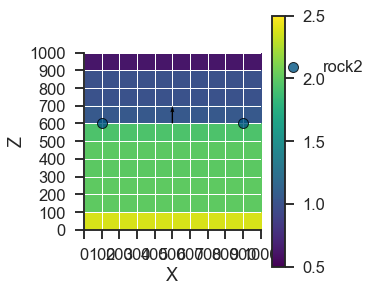

In [8]:
gp.plot.plot_section(geo_data, 0,
                     show_data=True,
                     cmap='viridis', show_grid=True)
plt.colorbar()

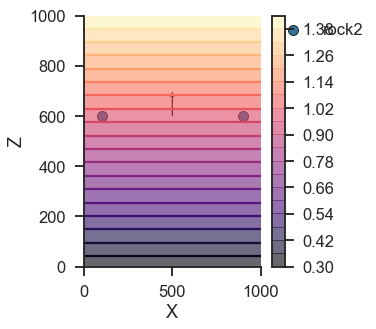

In [9]:
gp.plot.plot_scalar_field(geo_data, 0)
plt.colorbar()

### Calculating the jacobian

In [10]:
respect = geo_data.interpolator.theano_graph.input_parameters_loop[4]
th_f_j = theano.function(geo_data.interpolator.theano_graph.input_parameters_loop,
                         T.jacobian((geo_data.interpolator.theano_graph.compute_series()[0][-1]), 
                                respect),
                          # mode=NanGuardMode(nan_is_error=True),
                         on_unused_input='ignore')
print("Respect: " + str(respect))

/anaconda3/envs/gempy/lib/python3.7/site-packages/theano/gof/cc.py:968: UserWarning: Your g++ compiler fails to compile OpenMP code. We know this happen with some version of the EPD mingw compiler and LLVM compiler on Mac OS X. We disable openmp everywhere in Theano. To remove this warning set the theano flags `openmp` to False.
  ret += x.c_compile_args()


Respect: All the surface_points points at once


In [11]:
jac = th_f_j(*geo_data.interpolator.get_python_input_block())

In [12]:
jac.shape

(102, 2, 3)

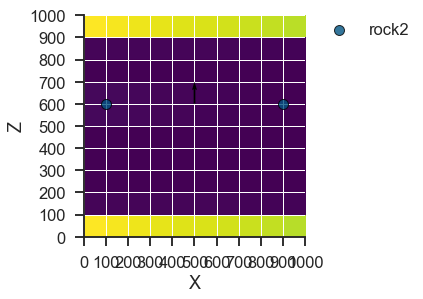

In [13]:
%matplotlib inline
point = 0

gp.plot.plot_section(geo_data, 0,
                     block=jac[:100, point, 2].reshape(geo_data.grid.regular_grid.resolution), show_data=True,
                     cmap='viridis', show_grid=True, norm=None)

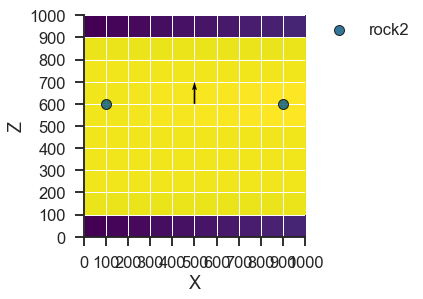

In [14]:
point = 1

gp.plot.plot_section(geo_data, 0,
                     block=jac[:100, point, 2].reshape(geo_data.grid.regular_grid.resolution), show_data=True,
                     cmap='viridis', show_grid=True, norm=None)
# ax = plt.gca();
# ax.set_xticks(np.linspace(-0, 1000, 11));
# ax.set_yticks(np.linspace(-0, 1000, 11));
# ax.grid(color='w', linestyle='-', linewidth=2)

### How changing values change the jacobian:

In [15]:
geo_data.surface_points

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,100,500,600,0.2501,0.5001,0.5001,rock2,Default series,1,1,1.000000e-08
2,900,500,600,0.7501,0.5001,0.5001,rock2,Default series,1,1,1.000000e-08


In [16]:
geo_data.modify_surface_points([0,2], X=[900, 100])

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,900,500,600,0.7501,0.5001,0.5001,rock2,Default series,1,1,1.000000e-08
2,100,500,600,0.2501,0.5001,0.5001,rock2,Default series,1,1,1.000000e-08


In [44]:
def prove_gradient(par_val = 500, var = 50, point_pos = 0):
    point = geo_data.surface_points.df.index[point_pos]


    # Compute values around the value of interest:
    arrays = np.array([])
    values_to_compute = np.linspace(par_val-var, par_val+var, 30)
    for i in values_to_compute:
        geo_data.modify_surface_points(point, Z=i, recompute_rescale_factor=True)
        sol = gp.compute_model(geo_data)
        arrays = np.append(arrays, sol.lith_block)
    
    # Compute jacobian
    geo_data.modify_surface_points(point, Z=par_val, recompute_rescale_factor=True)
    jac = th_f_j(*geo_data.interpolator.get_python_input_block())

    
    # Plot values
    iter_a = arrays.reshape(-1, 10, 10)
    fig= plt.figure()
    plt.axis('off')

    for i in range(10):
        for j in range(10):
           # print(i,j, (9-j)*10+i+1)
            ax = plt.subplot(10,  10, (9-j)*10+i+1)#((1+j)*10)-i)
            ax.plot(values_to_compute, iter_a[:, i, j], '.')
            ax.axvline(par_val, ymax=3, color='r')
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            # ax.sharex()
            ax.set_ylim(0,3)

    gp.plot.plot_section(geo_data, 0,
                         block=jac[:100, point_pos, 2].reshape(geo_data.grid.regular_grid.resolution), show_data=True,
                         cmap='viridis', show_grid=True, norm=None
                        )
    return iter_a, jac[:100, point_pos, 2].reshape(geo_data.grid.regular_grid.resolution)

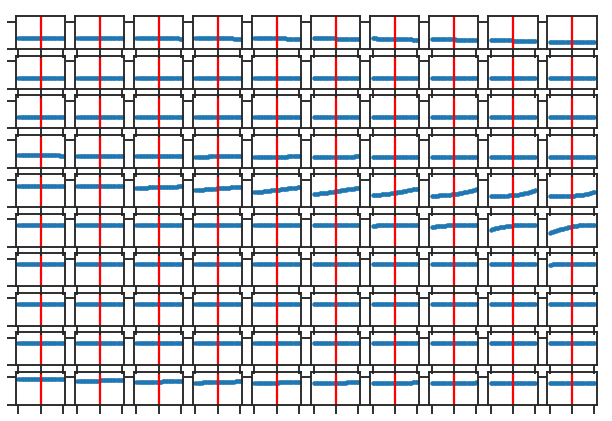

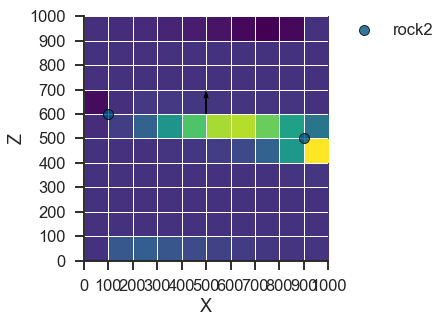

In [36]:
prove_gradient(par_val = 500, var = 50, point_pos = 0);

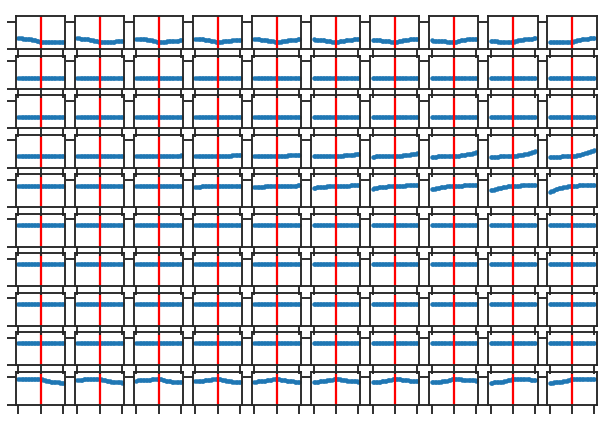

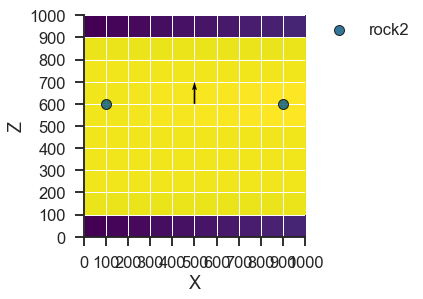

In [37]:
prove_gradient(par_val = 600, var = 50, point_pos = 0);

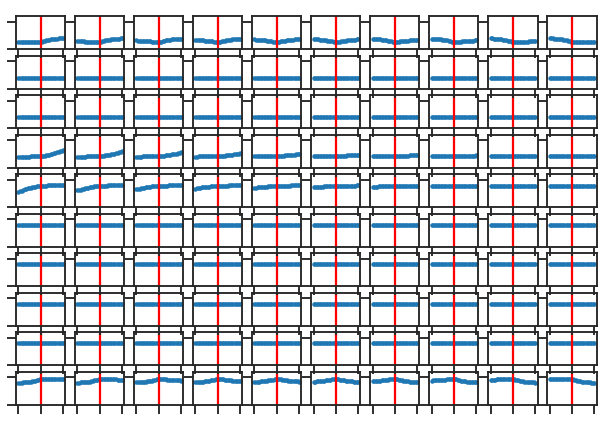

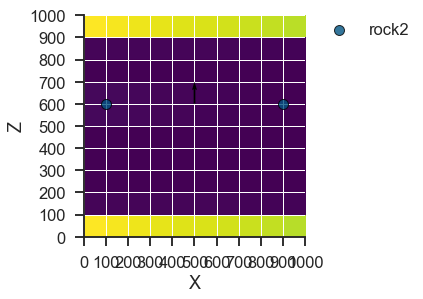

In [38]:
#%matplotlib notebook
prove_gradient(par_val = 600, var = 50, point_pos = 1);

<IPython.core.display.Javascript object>


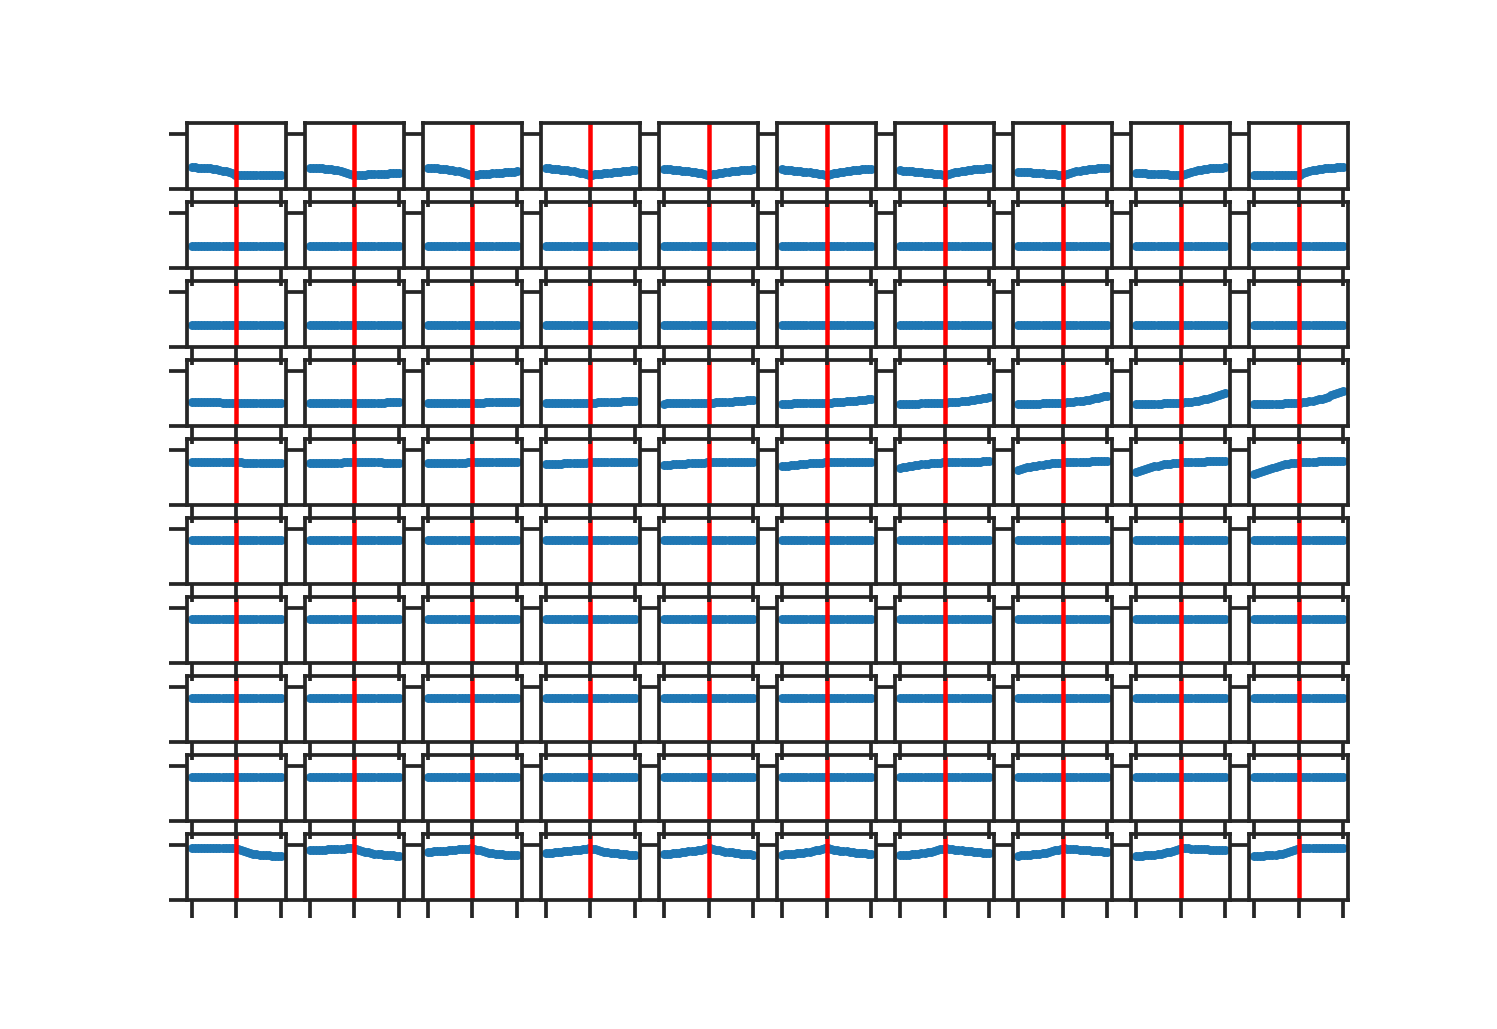

<IPython.core.display.Javascript object>


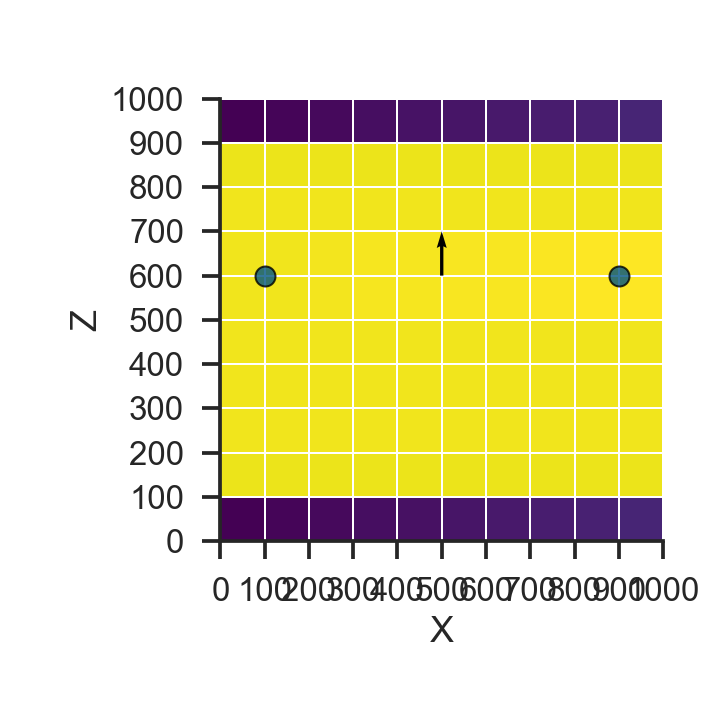

In [45]:
%matplotlib notebook
foo, _j  = prove_gradient(par_val = 600, var = 50, point_pos = 0);

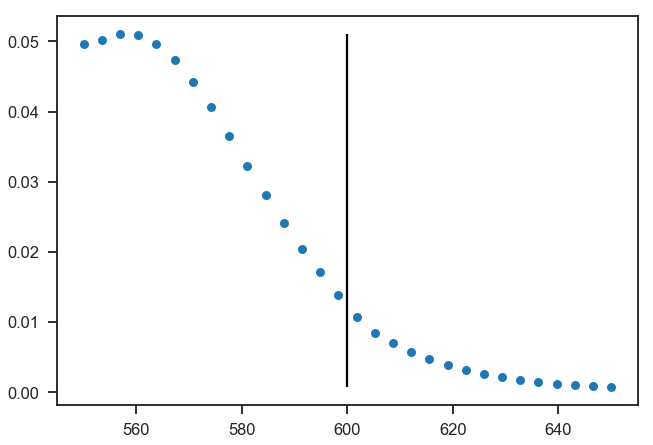

In [22]:
fig = plt.figure()
par_val = 600
var = 50


x =  np.linspace(par_val-var, par_val+var, 30)
y = np.gradient(foo[:, 9, 5])
plt.plot(x, y, 'o')
plt.vlines(600, y.min(),y.max() )

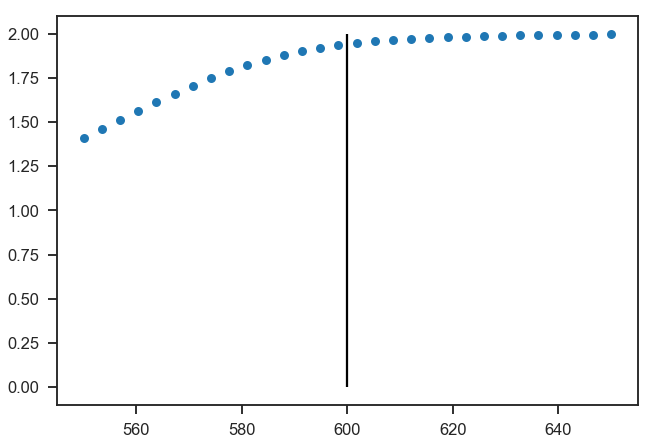

In [23]:
fig = plt.figure()

plt.plot(x, foo[:, 9, 5], 'o')
plt.vlines(600, 0,2 )

In [46]:
ff = np.array([])
gg = np.array([])
for i in range(10):
    for j in range(10):
        gg = np.append(gg, foo[:, i, j][14])
        ff = np.append(ff, np.diff(foo[:, i, j])[14])

In [47]:
gg

array([2.37754067, 2.00237018, 2.0000093 , 1.99999909, 1.99975788,
       1.94181908, 1.05969607, 1.00024078, 0.99790812, 0.65179174,
       2.37377981, 2.00233254, 2.00000915, 1.99999907, 1.99975391,
       1.94091806, 1.05878624, 1.00023663, 0.99787404, 0.64812935,
       2.37024362, 2.00229792, 2.00000902, 1.99999906, 1.99975024,
       1.94009083, 1.05797358, 1.00023291, 0.99784236, 0.64473082,
       2.36691454, 2.00226612, 2.0000089 , 1.99999904, 1.99974693,
       1.93934986, 1.05726341, 1.00022964, 0.99781335, 0.64160037,
       2.36373609, 2.00223643, 2.00000878, 1.99999903, 1.9997439 ,
       1.93868108, 1.05663635, 1.00022672, 0.99778645, 0.63867412,
       2.36061926, 2.00220774, 2.00000868, 1.99999902, 1.99974097,
       1.9380375 , 1.05604504, 1.00022396, 0.99776019, 0.63581991,
       2.35746319, 2.0021788 , 2.00000857, 1.999999  , 1.99973787,
       1.93735513, 1.05543061, 1.00022111, 0.99773265, 0.63287484,
       2.35418192, 2.00214862, 2.00000845, 1.99999899, 1.99973

<IPython.core.display.Javascript object>


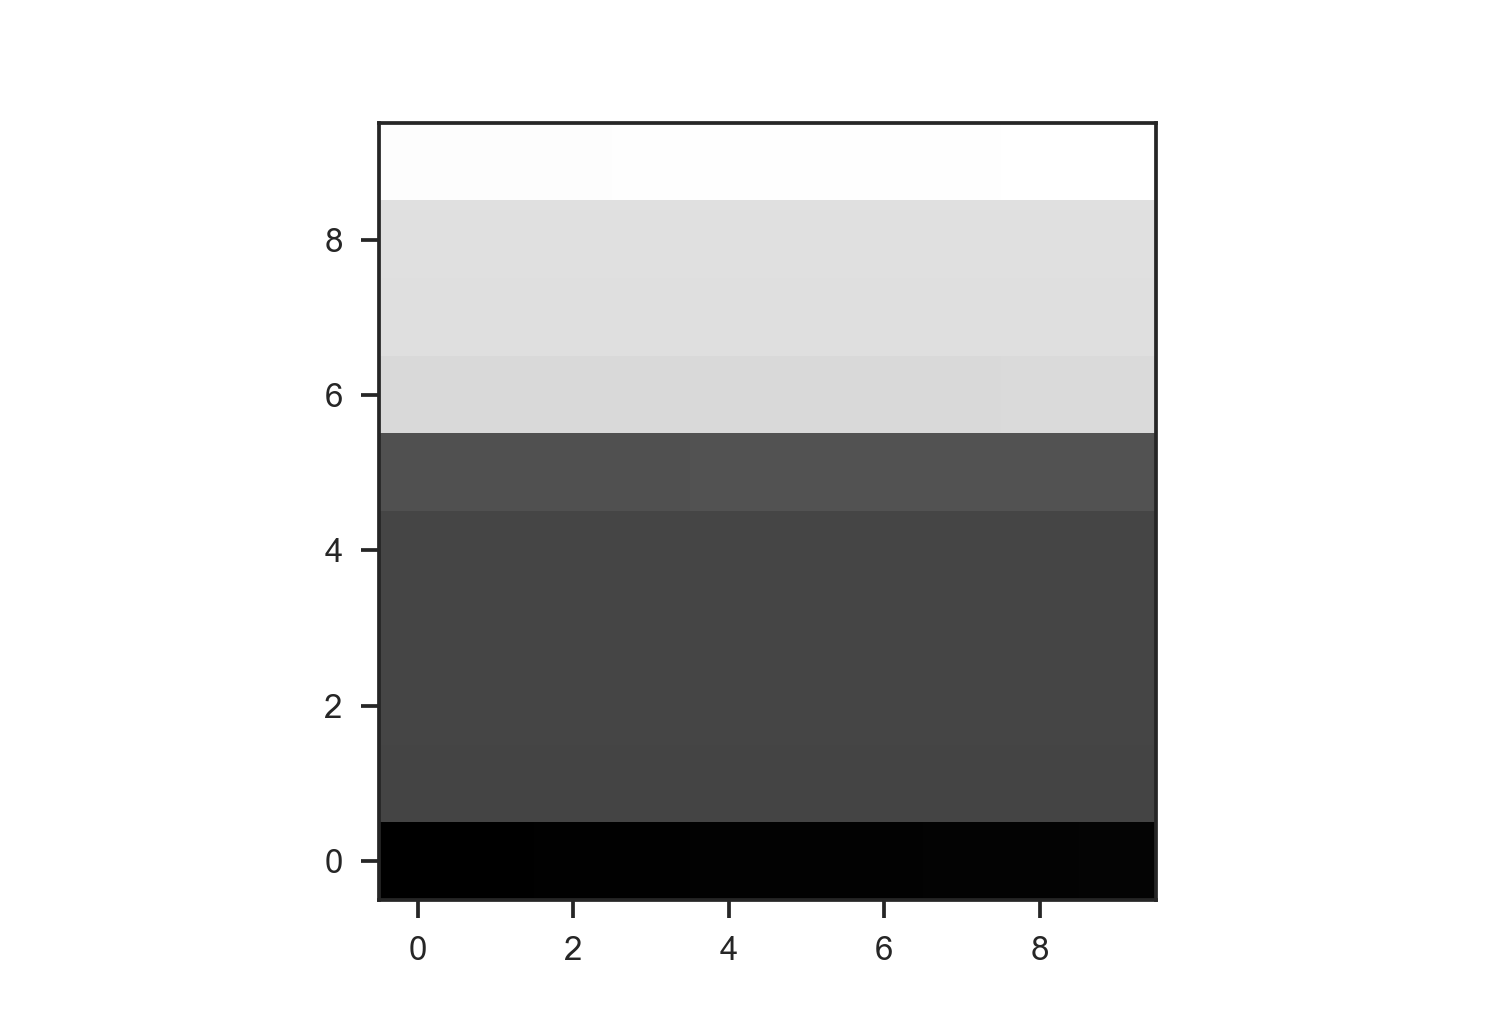

In [48]:
plt.figure()
plt.imshow(gg.reshape(10, 10).T, origin='bottom')

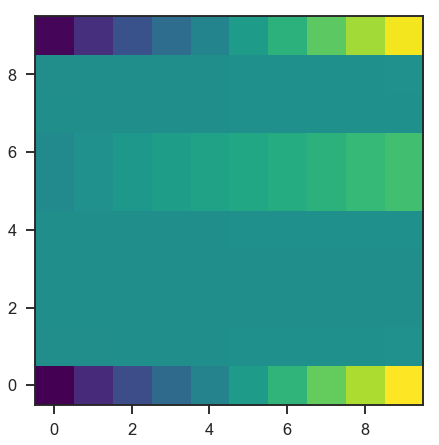

In [27]:
plt.figure()
plt.imshow(ff.reshape(10, 10).T, origin='bottom', cmap='viridis')

<IPython.core.display.Javascript object>


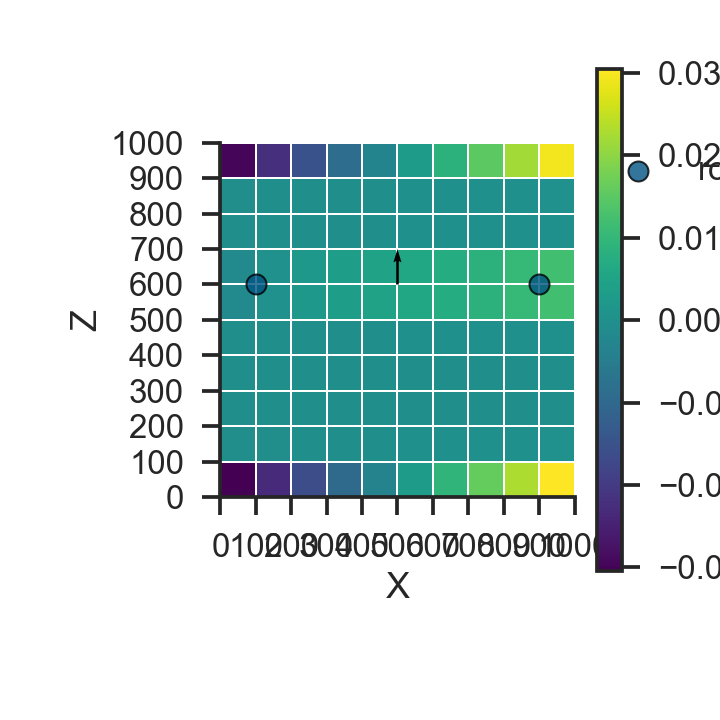

In [49]:

gp.plot.plot_section(geo_data, 0,
                     block=ff.reshape(10, 10).reshape(geo_data.grid.regular_grid.resolution), show_data=True,
                     cmap='viridis', show_grid=True, norm=None)
plt.colorbar()

<IPython.core.display.Javascript object>


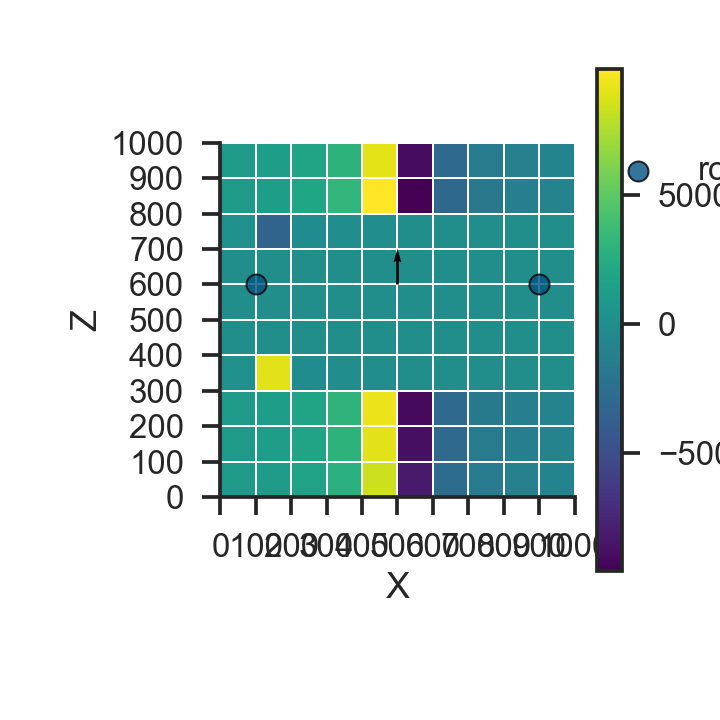

In [54]:
sect = _j/ ff.reshape(10, 10).reshape(geo_data.grid.regular_grid.resolution)

gp.plot.plot_section(geo_data, 0,
                     block=sect, show_data=True,
                     cmap='viridis', show_grid=True, norm=None)
plt.colorbar()

In [7]:
import theano.gpuarray.linalg

theano.gpuarray.linalg.gpu_solve??

----------